In [1]:
import pandas as pd
import numpy as np
# %matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from itertools import combinations
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from kneed import KneeLocator
from collections import Counter, defaultdict

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def import_data(file_name, col_list, seperator):
    df = pd.read_csv(file_name, sep=seperator, usecols=col_list )
    return df

In [4]:
def all_clusters(df, max_pair_size, n, plot_locals = False):
    col_list = list(df.columns)
    col_list.remove('CID')
    pairlist_1d = []
    for i in range(len(col_list)):
        pairlist_1d.append([col_list[i]])
    cluster_pair_list(df, pairlist_1d, n, plot_locals)
    for tuple_size in range(2, max_pair_size+1):
        li = list(combinations(col_list, tuple_size))
#         li.insert(0, 'CID')
        cluster_pair_list(df, li, n, plot_locals)

In [5]:
def cluster_pair_list(df, pair_list, n, plot_locals = False):
    for pair in pair_list:
        df1 = df[list(pair)]
        scaler = StandardScaler()
        df_norm = pd.DataFrame(scaler.fit_transform(df1),columns = df1.columns)
        no_of_clusters = k_opt_elbow(df_norm)
        kmeans = KMeans(n_clusters=no_of_clusters)
        distance = kmeans.fit_transform(df_norm)
        center_norm = kmeans.cluster_centers_
        center = scaler.inverse_transform(center_norm)
        labels = kmeans.labels_
        df1['labels'] = labels
        
        local_c, local_f = local_closests_farthests(df_norm, distance, labels, n)
        outliers = global_outliers(df_norm, list(pair), center_norm)
        local_c[list(pair)] = scaler.inverse_transform(local_c[list(pair)])
        local_f[list(pair)] = scaler.inverse_transform(local_f[list(pair)])
        outliers[list(pair)] = scaler.inverse_transform(outliers[list(pair)])
        
        x = df.columns[0]
#         print(x)
        local_c_cid_list = []
        local_f_cid_list = []
        outliers_cid_list = []
        for i in local_c.index.values:
            local_c_cid_list.append(df.iloc[i][x])
        for i in local_f.index.values:
            local_f_cid_list.append(df.iloc[i][x])
        for i in outliers.index.values:
            outliers_cid_list.append(df.iloc[i][x])
        
        local_c[x] = local_c_cid_list
        local_f[x] = local_f_cid_list
        outliers[x] = outliers_cid_list
        pair = list(pair)
        pair.append(x)
        
        plot_clusters(df1, outliers, local_c, local_f, pair, center, labels, plot_locals)

In [6]:
def k_opt_elbow(df):
    K = range(2, 10)
    inertia = []
    for k in K:
        kmeans = KMeans(n_clusters=k).fit(df) 
        kmeans.fit_transform(df)
        inertia.append(kmeans.inertia_)

    kn = KneeLocator(K, inertia, curve='convex', direction='decreasing')
    return (kn.knee)

In [7]:
def plot_clusters(df, outliers, local_c, local_f, col_list, center, labels, plot_locals = False):
    fig1 = plt.figure(figsize=(18, 25))
    gs = gridspec.GridSpec(12,2)
    ax1 = fig1.add_subplot(gs[0:4, :])
    ax2 = fig1.add_subplot(gs[4:5, :])
    ax3 = fig1.add_subplot(gs[6:7, :])
    ax4 = fig1.add_subplot(gs[8:9, :])
    ax5 = fig1.add_subplot(gs[10:11, :])
    ax2.axis('tight')
    ax2.axis('off')
    ax3.axis('tight')
    ax3.axis('off')
    ax4.axis('tight')
    ax4.axis('off')
    ax5.axis('tight')
    ax5.axis('off')
    ax3.set_title('Local Closests for each Cluster', y=1.4)
    ax4.set_title('Local Farthests for each Cluster', y=1.4)
    ax5.set_title('Global Outliers', y=1.35)
    
    if len(col_list)==2:
        df.reset_index().plot(kind='scatter',x='index',y=col_list[0], c=labels, cmap='viridis', ax=ax1)
        outliers.reset_index().plot(kind='scatter',x='index',y=1, marker='+' ,c='k',s=150, ax=ax1)
        if plot_locals:
            local_c.reset_index().plot(kind='scatter',x='index',y=col_list[0], c='b', ax=ax1, marker='x', s=80)
            local_f.reset_index().plot(kind='scatter',x='index',y=col_list[0], c='m', ax=ax1, marker='x', s=80)
        ax1.set_title(col_list[0] + ' per Customer')
        
        clusters_indices = defaultdict(list)
        for index, c  in enumerate(labels):
            clusters_indices[c].append(index)
        table1_rows = []
        for i in range (len(clusters_indices)):
            table1_rows.append([i, min(df.iloc[clusters_indices[i],0]), max(df.iloc[clusters_indices[i],0]), len(clusters_indices[i])])
        headers = ['Cluster#', 'min ' + col_list[0], 'max ' + col_list[0], 'Cluster Size']
        tab1 = ax2.table(cellText=table1_rows, colLabels=headers, colColours =["palegreen"] * 10, loc='top', bbox=[0, -0.5, 0.9, 0.9])
        
        col_list.insert(0, 'labels')
        table2_rows = local_c[col_list].values.tolist()
        tab2 = ax3.table(cellText=table2_rows, colLabels=col_list, colColours =["palegreen"] * 10, loc='top', bbox=[0, -0.3, 0.9, 1.7])
        table3_rows = local_f[col_list].values.tolist()
        tab3 = ax4.table(cellText=table3_rows, colLabels=col_list, colColours =["palegreen"] * 10, loc='top', bbox=[0, -0.3, 0.9, 1.7])
        table5_rows = outliers[col_list].values.tolist()
        tab4 = ax5.table(cellText=table5_rows, colLabels=col_list, colColours =["palegreen"] * 10, loc='top', bbox=[0, 0.2, 0.9, 1.1])
        
    elif len(col_list)==3:
        df.plot(kind='scatter',x=col_list[0],y=col_list[1],c=labels, cmap='viridis', ax=ax1)
        ax1.scatter(center[:,0],center[:,1], c='r', marker='*', s=80)
        outliers.plot(kind='scatter',x=0,y=1, marker='+' ,c='k',s=150, ax=ax1)
        if plot_locals:
            local_c.reset_index().plot(kind='scatter',x=col_list[0],y=col_list[1], c='b', ax=ax1, marker='x', s=80)
            local_f.reset_index().plot(kind='scatter',x=col_list[0],y=col_list[1], c='m', ax=ax1, marker='x', s=80)
        ax1.set_title(col_list[0] + ' vs ' + col_list[1])
        
        clusters_indices = defaultdict(list)
        for index, c  in enumerate(labels):
            clusters_indices[c].append(index)
        table_rows = []
        for i in range (len(clusters_indices)):
            table_rows.append([i, (min(df.iloc[clusters_indices[i],0]), max(df.iloc[clusters_indices[i],0])), (min(df.iloc[clusters_indices[i],1]), max(df.iloc[clusters_indices[i],1])), len(clusters_indices[i])])
        headers = ['Cluster#', '(min ' + col_list[0]+' , max'+ col_list[0] +')', '(min ' + col_list[1]+' , max'+ col_list[1] +')', 'Cluster Size']
        ax2.axis('tight')
        ax2.axis('off')
        tab1 = ax2.table(cellText=table_rows, colLabels=headers, colColours =["palegreen"] * 10, loc='center', bbox=[0, -0.5, 0.9, 0.9])
        tab1.auto_set_font_size(False)
        tab1.set_fontsize(10)

        col_list.insert(0, 'labels')
        table2_rows = local_c[col_list].values.tolist()
        tab2 = ax3.table(cellText=table2_rows, colLabels=col_list, colColours =["palegreen"] * 10, loc='top', bbox=[0, -0.3, 0.9, 1.7])
        table3_rows = local_f[col_list].values.tolist()
        tab3 = ax4.table(cellText=table3_rows, colLabels=col_list, colColours =["palegreen"] * 10, loc='top', bbox=[0, -0.3, 0.9, 1.7])
        table5_rows = outliers[col_list].values.tolist()
        tab4 = ax5.table(cellText=table5_rows, colLabels=col_list, colColours =["palegreen"] * 10, loc='top', bbox=[0, 0.2, 0.9, 1.1])
        
    elif len(col_list)==4:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(df[col_list[0]], df[col_list[1]], df[col_list[2]], c=labels, cmap='viridis')
        ax.scatter(center[:,0],center[:,1],center[:,2], c='r', s=50)
        ax.scatter(outliers[col_list[0]], outliers[col_list[1]], outliers[col_list[2]], c='k', s=100, marker='+')
        ax.scatter(local_c[col_list[0]], local_c[col_list[1]], local_c[col_list[2]], c='b', s=40, marker='x')
        ax.scatter(local_f[col_list[0]], local_f[col_list[1]], local_f[col_list[2]], c='m', s=40, marker='x')
        
    else:
        col_list = col_list + ('labels',)
        print('\n' + '\033[1m' + 'The data with corresponding cluster labels:' +'\033[0m')
        print(df[list(col_list)])
        print('\n' + '\033[1m' + 'Global outliers:' +'\033[0m')
        print(outliers[list(col_list)])
        print('\n' + '\033[1m' +'Local closests:' + '\033[0m')
        print(local_c[list(col_list)])
        print('\n' + '\033[1m' +'Local farthests:' + '\033[0m')
        print(local_f[list(col_list)])
    
    if(len(col_list)-1==1):
        ax1.legend(('Cluster pts', 'Outliers', 'Local closests', 'Local farthests'), loc='best')
    elif(len(col_list)-1<4):
        ax1.legend(('Cluster pts', 'Centroids', 'Outliers', 'Local closests', 'Local farthests'), loc='best')

    tab2.auto_set_column_width(col=list(range(len(local_c.columns))))
    tab3.auto_set_column_width(col=list(range(len(local_f.columns))))
    tab4.auto_set_column_width(col=list(range(len(outliers.columns))))
    tab1.auto_set_font_size(False)
    tab1.set_fontsize(10)
    tab2.auto_set_font_size(False)
    tab2.set_fontsize(9)
    tab3.auto_set_font_size(False)
    tab3.set_fontsize(9)
    tab4.auto_set_font_size(False)
    tab4.set_fontsize(10)

In [8]:
def local_closests_farthests(df, distance, labels, n):
    distance = distance**2
    distance = distance.min(axis=1)
    df['Dist'] = distance
    df['labels'] = labels
    local_c = pd.DataFrame()
    local_f = pd.DataFrame()

    for l in np.unique(labels):
        X = df[df['labels']==l]
        X.sort_values(['Dist'], inplace=True)
        local_c = local_c.append(X.head(n))
    for l in np.unique(labels):
        X = df[df['labels']==l]
        X.sort_values(['Dist'], inplace=True, ascending=[0])
        local_f = local_f.append(X.head(n))
    return local_c, local_f

In [9]:
def global_outliers(df, pair, center):
    n = len(center)
    global_center = 0
    for i in range (n):
        global_center = global_center + center[i,:]
    global_center = global_center/n
    df['distance'] = np.linalg.norm(df[pair].sub(np.array(global_center)), axis=1)
    df = df.sort_values(['distance'], ascending=[0]).iloc[0:5, :]
    return df

In [10]:
col_list = ['CID', 'DCID', 'CLUSTID', 'CLUST_VM_Count', 'CLUST_HOST_Count', ' HOST_VMCount ', 'HOSTID']
data = import_data('dc_cluster_host.csv', col_list, ',')
# data.head(50)

In [11]:
df1 = data[['CID', 'DCID']]
df1 = df1.groupby(by='CID', as_index=False).agg({'DCID': pd.Series.nunique})
df1 = df1.rename(columns={'DCID': 'DC_Count'})

df2 = data[['CID', 'CLUSTID']]
df2 = df2.groupby(by=['CID'], as_index=False).agg({'CLUSTID': pd.Series.nunique})
df2 = df2.rename(columns={'CLUSTID': 'CLUST_Count'})

df3 = data[['CID', 'HOSTID']]
df3 = df3.groupby(by=['CID'], as_index=False).agg({'HOSTID': pd.Series.nunique})
df3 = df3.rename(columns={'HOSTID': 'HOST_Count'})

df4 = data[['CID', ' HOST_VMCount ']]
df4 = df4.groupby(by=['CID'], as_index=False)[' HOST_VMCount '].sum()
df4 = df4.rename(columns={' HOST_VMCount ': 'VM_Count'})

df_customer = pd.merge(df1, df2, on='CID')
df_customer = pd.merge(df_customer, df3, on='CID')
df_customer = pd.merge(df_customer, df4, on='CID')
# df_customer.head(10)

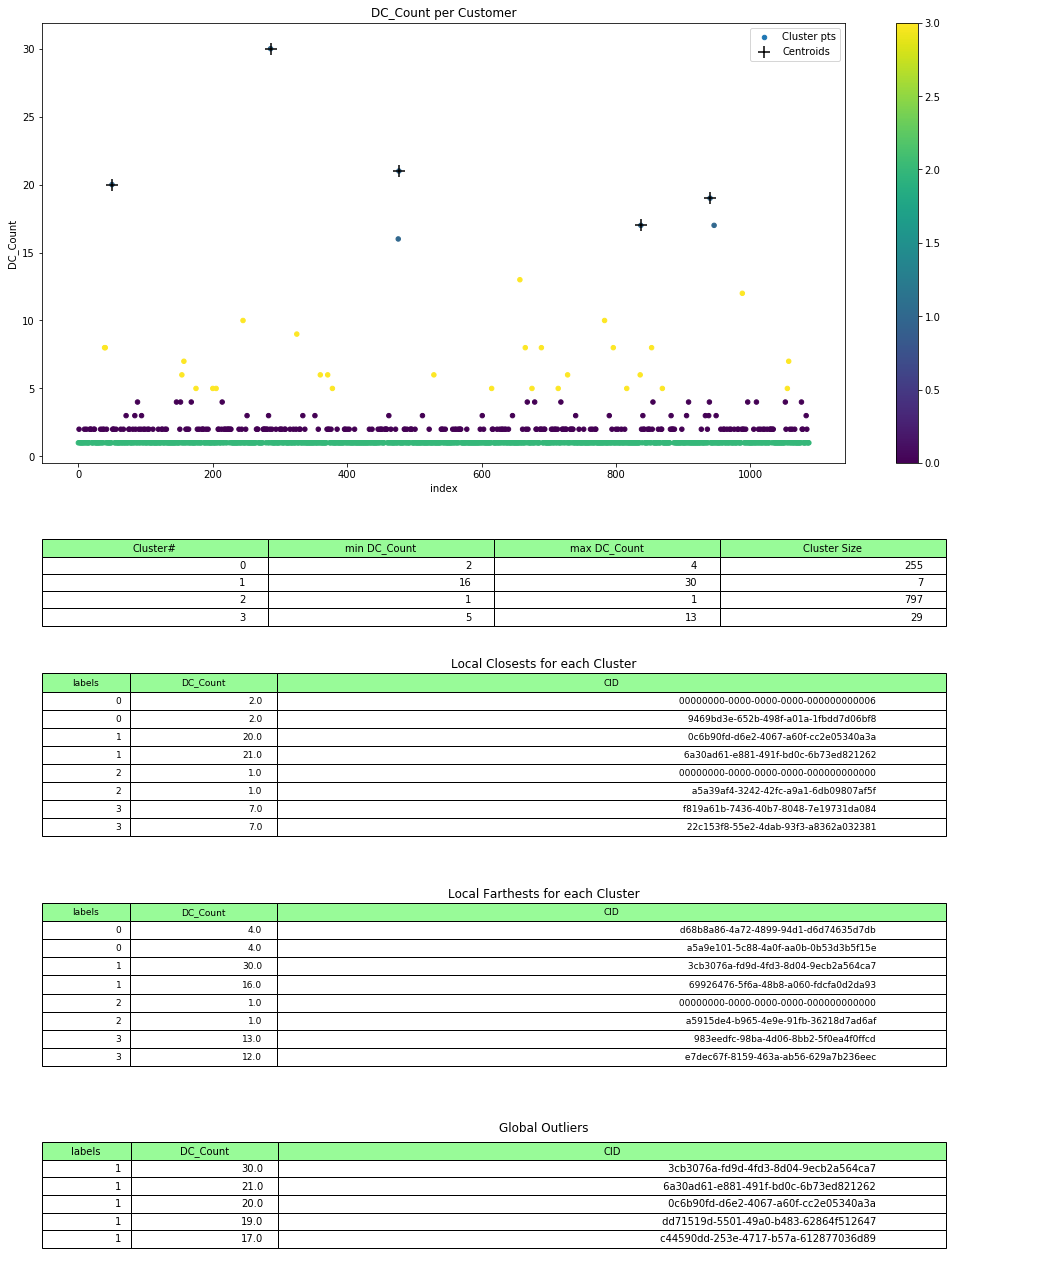

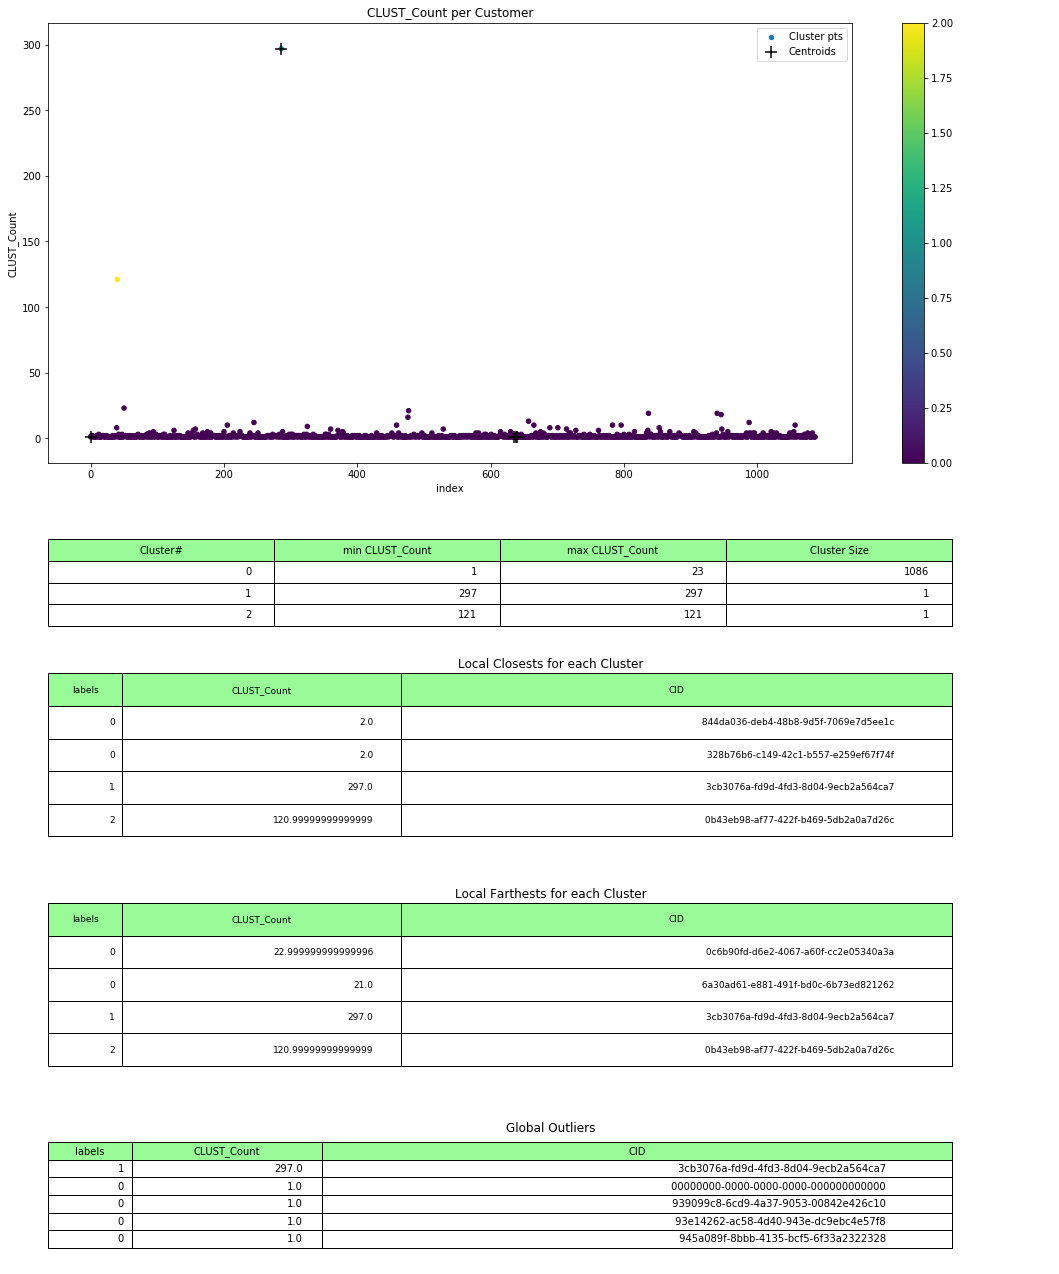

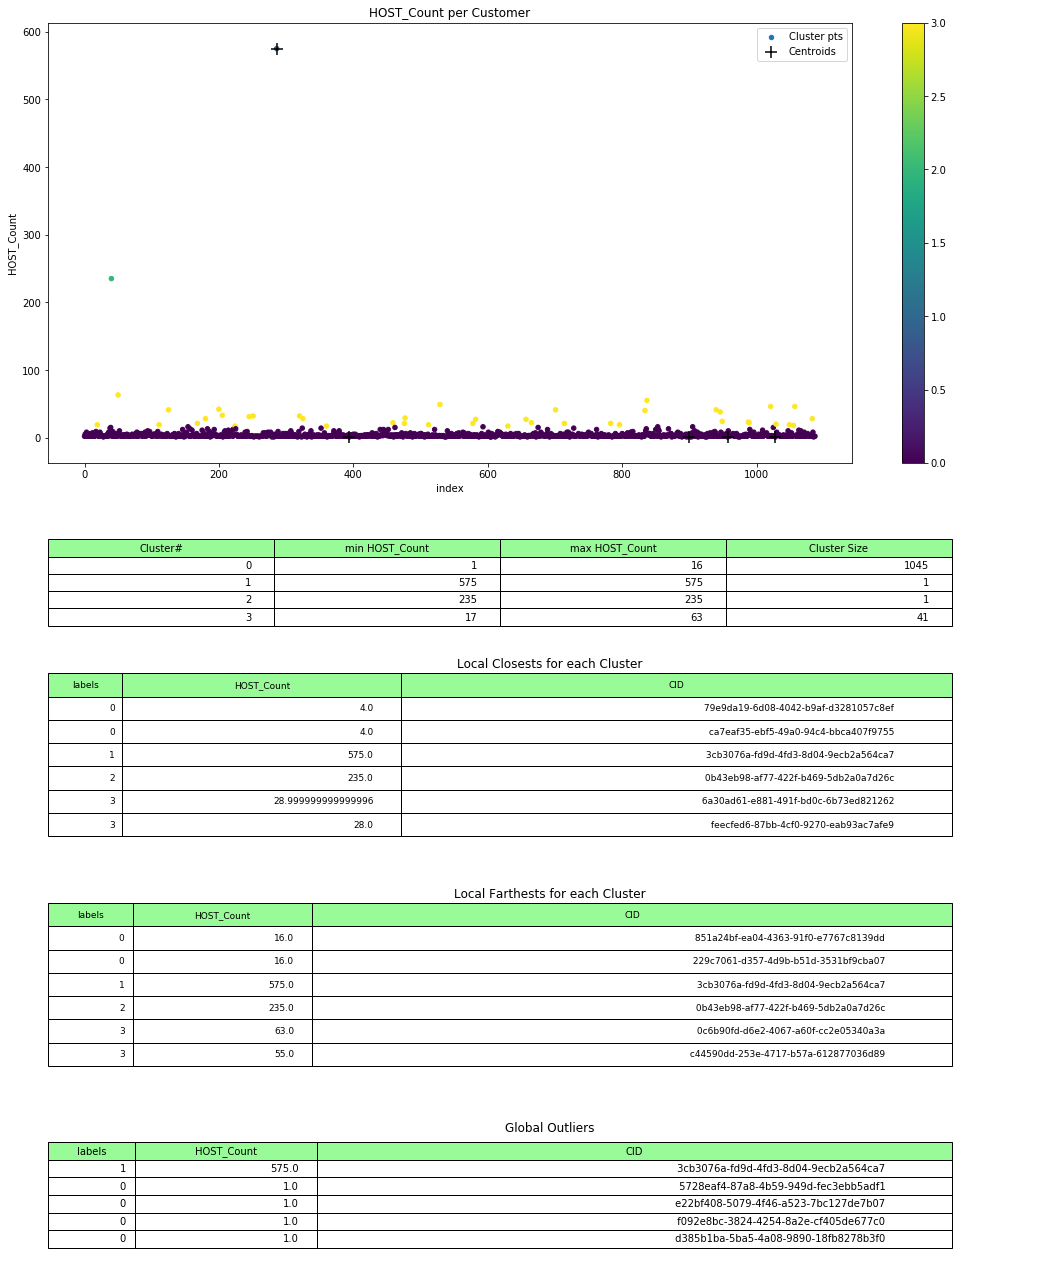

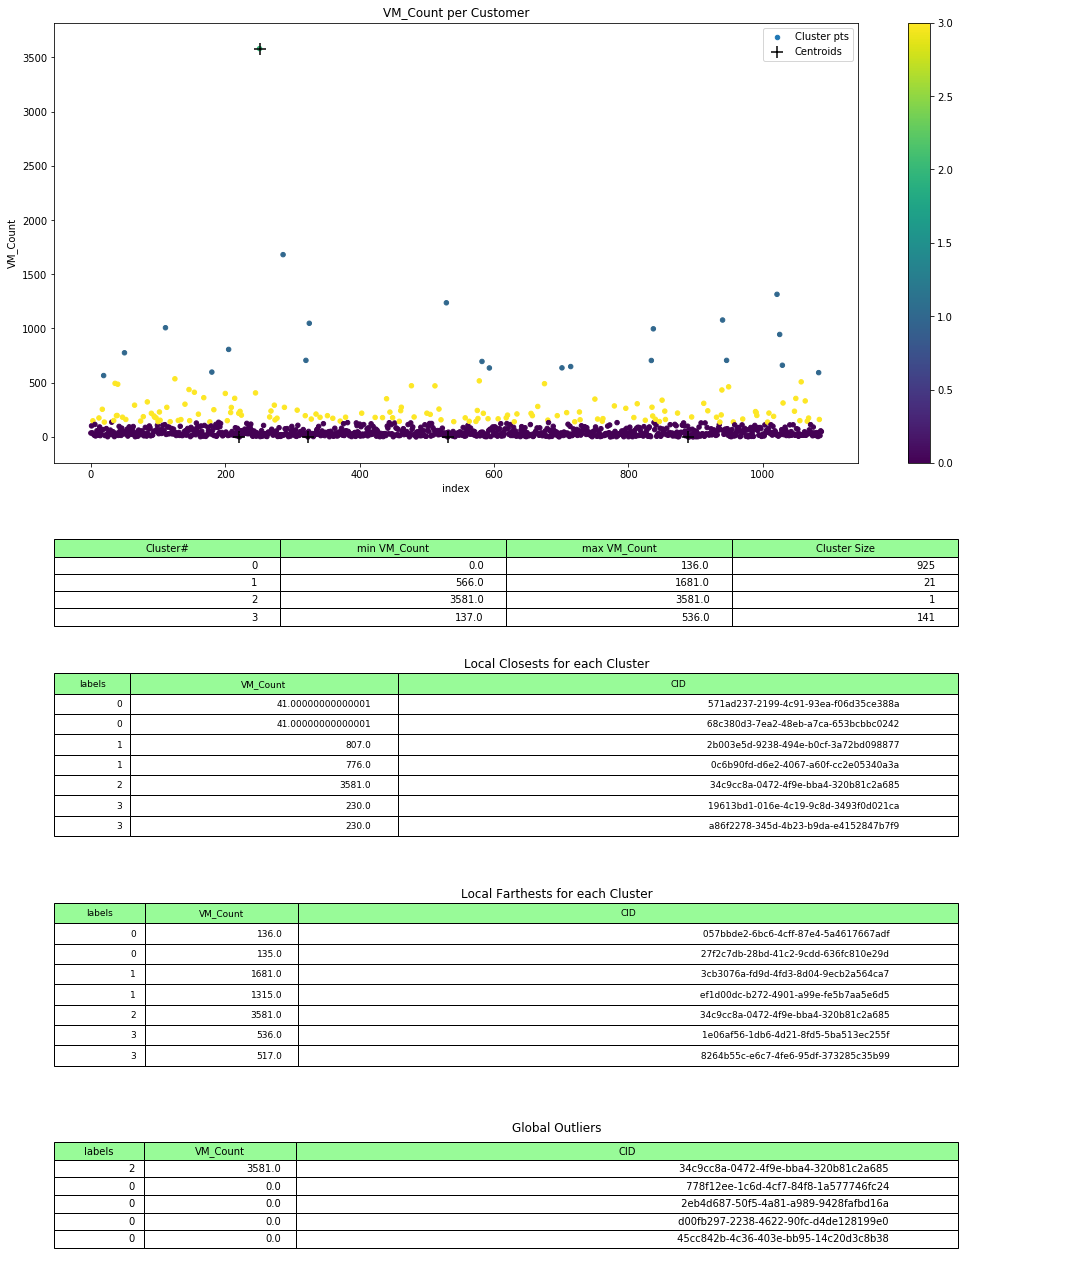

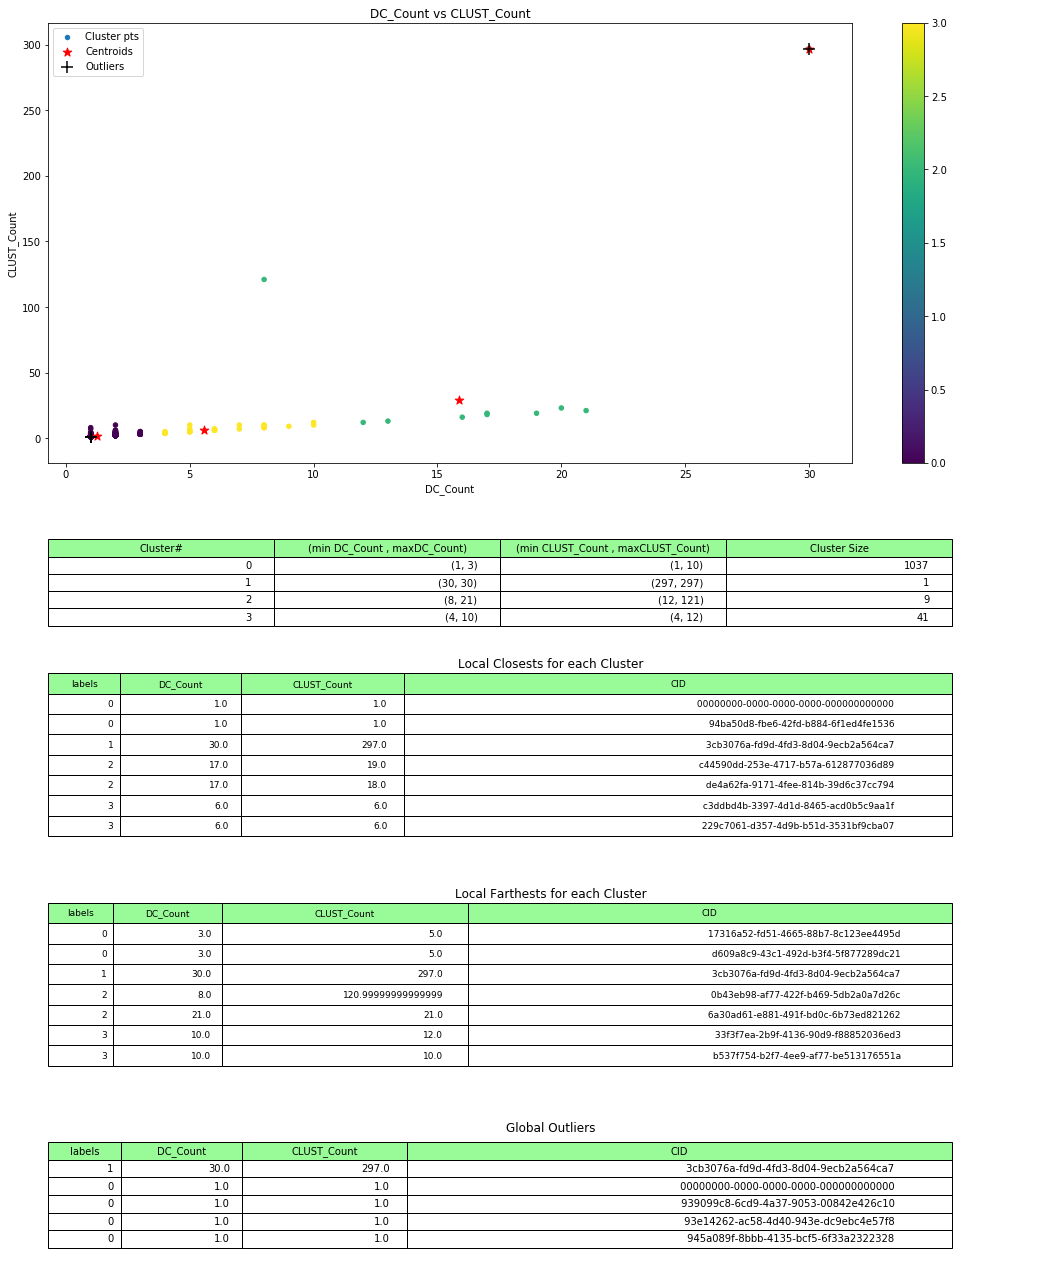

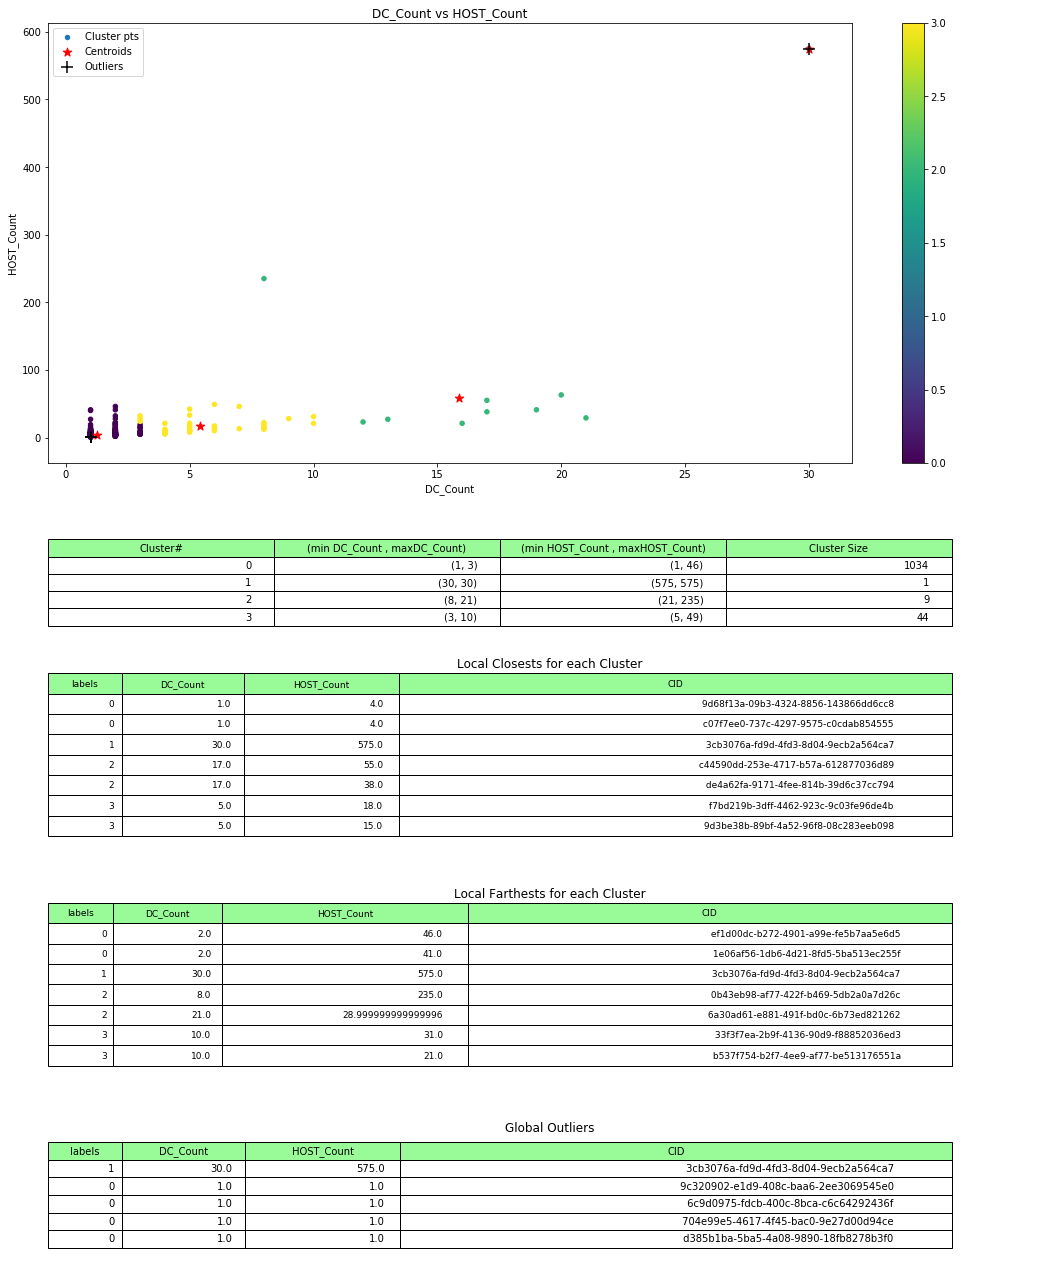

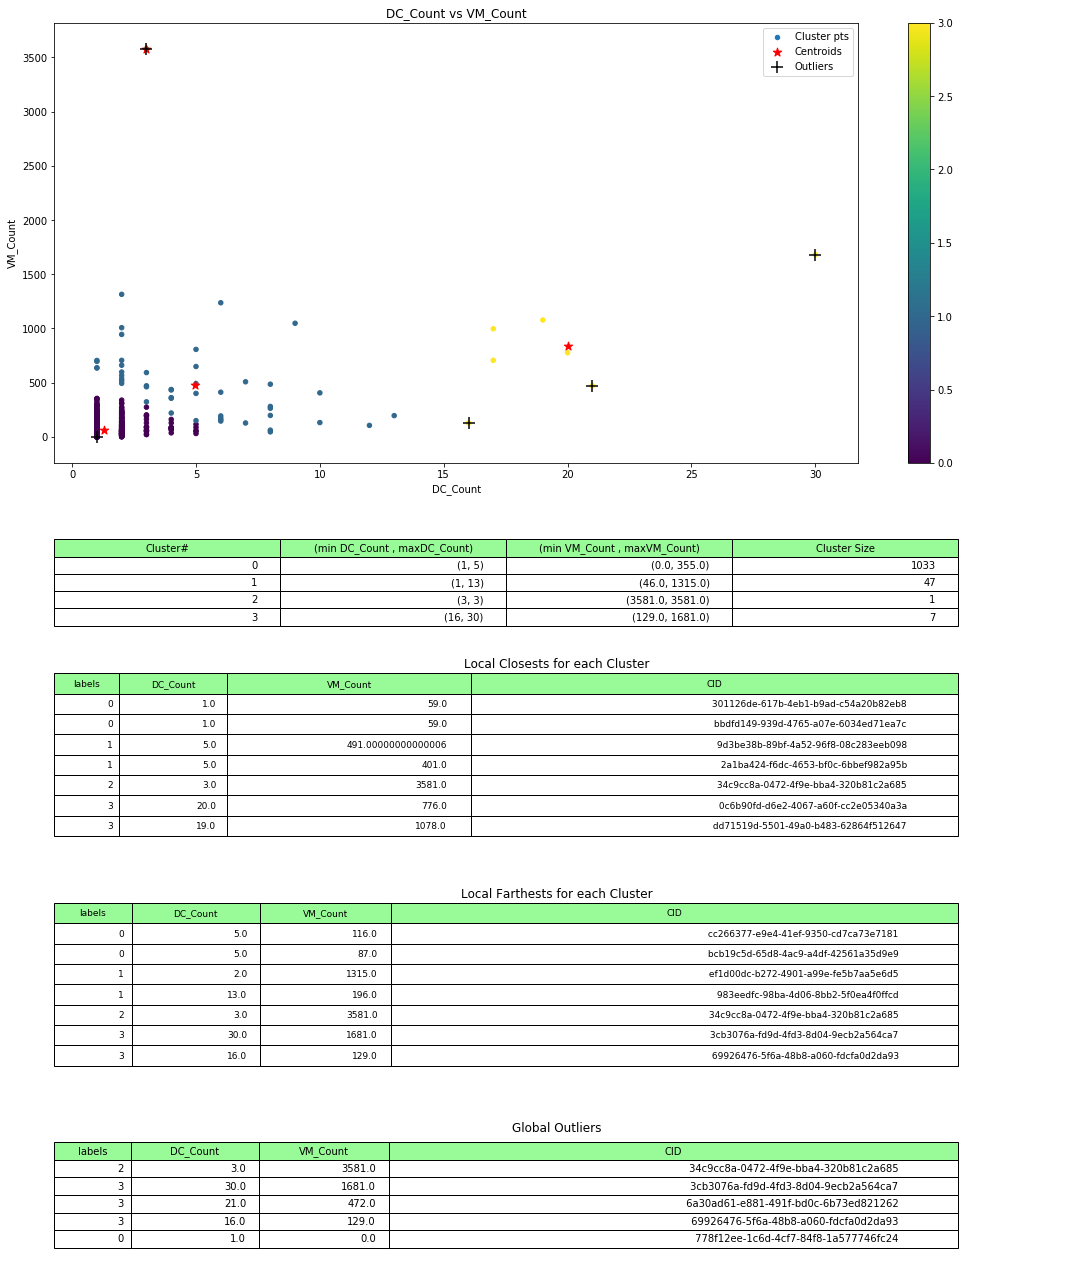

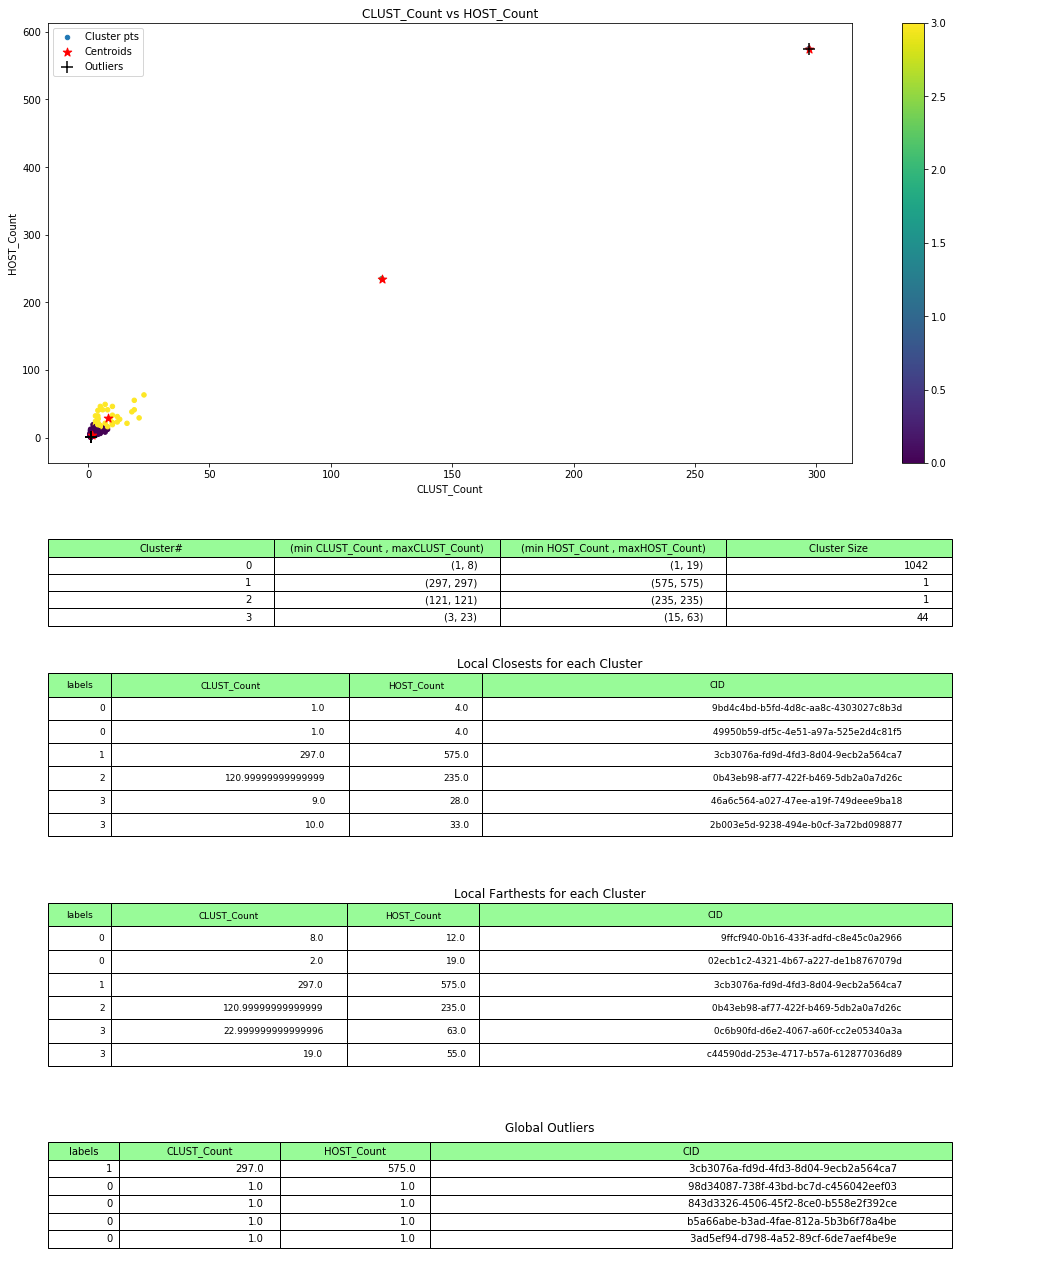

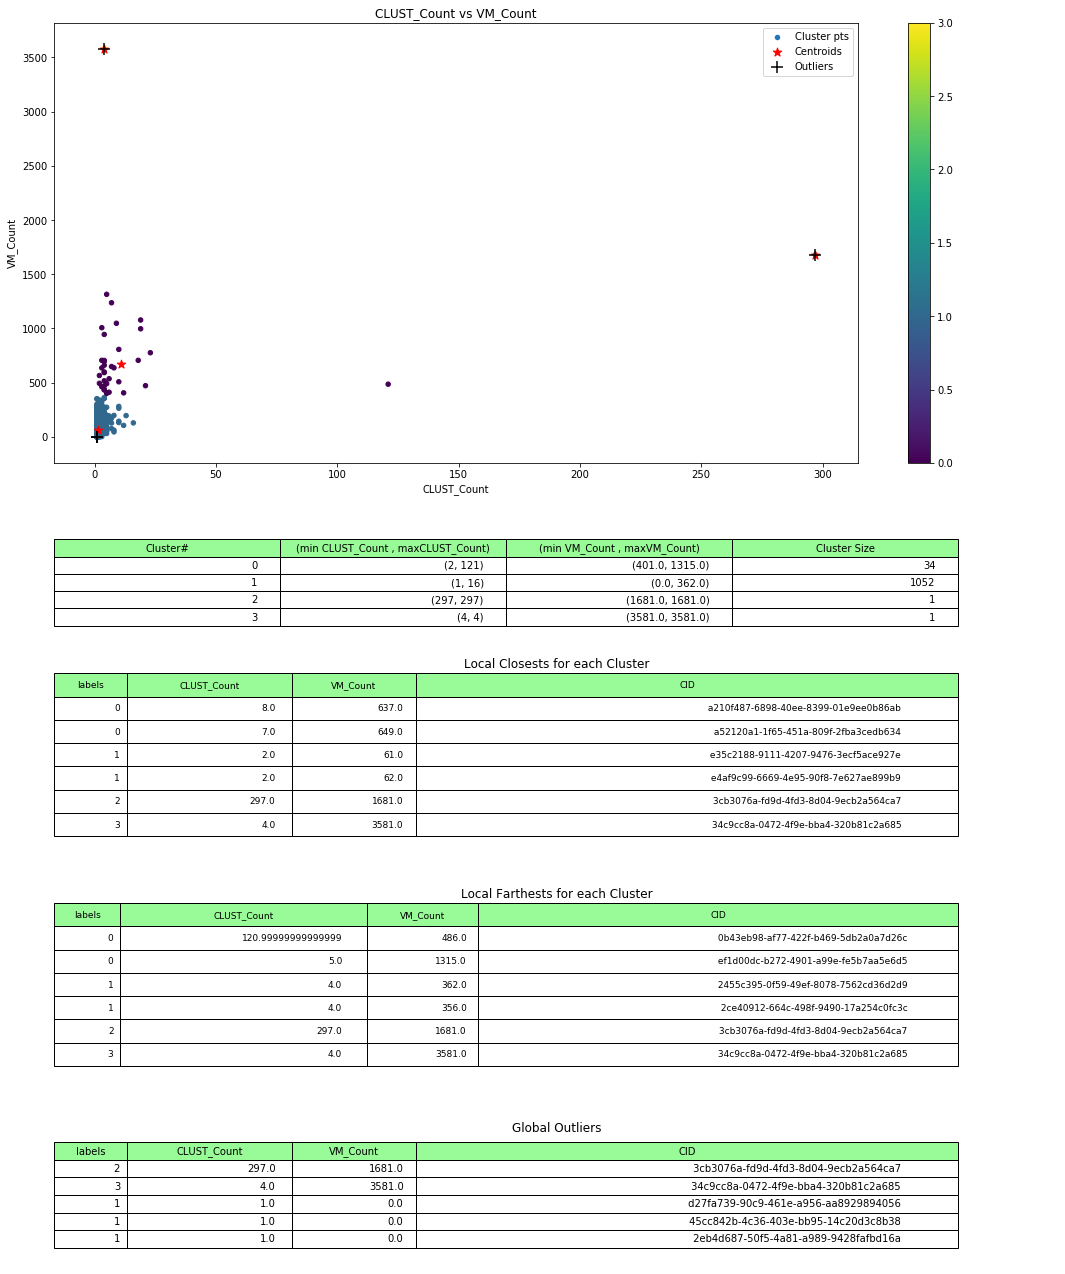

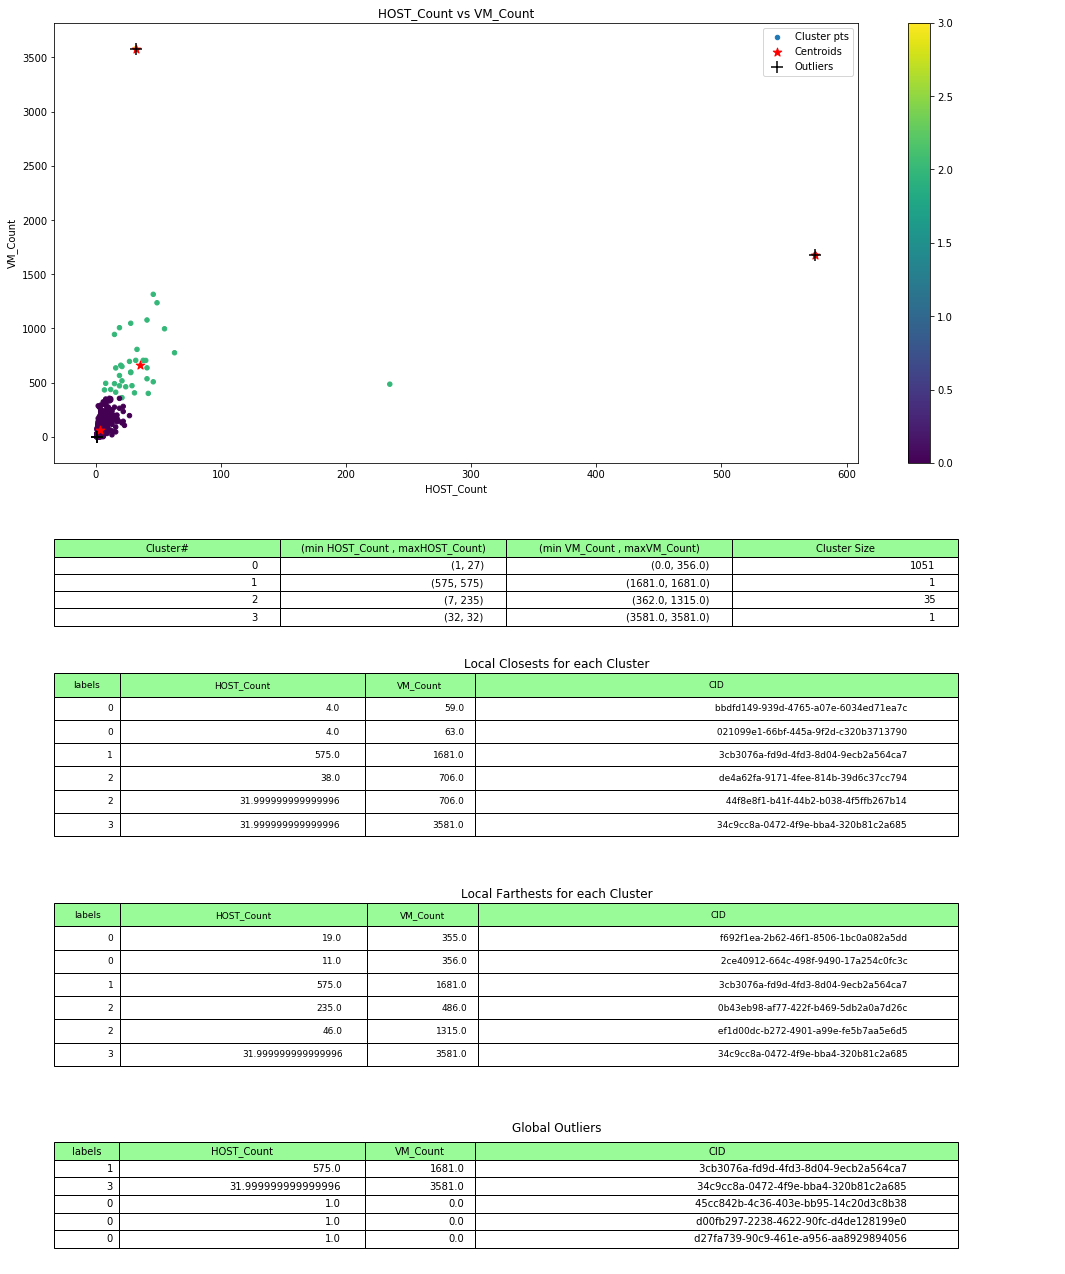

In [12]:
all_clusters(df_customer, 2, 2)

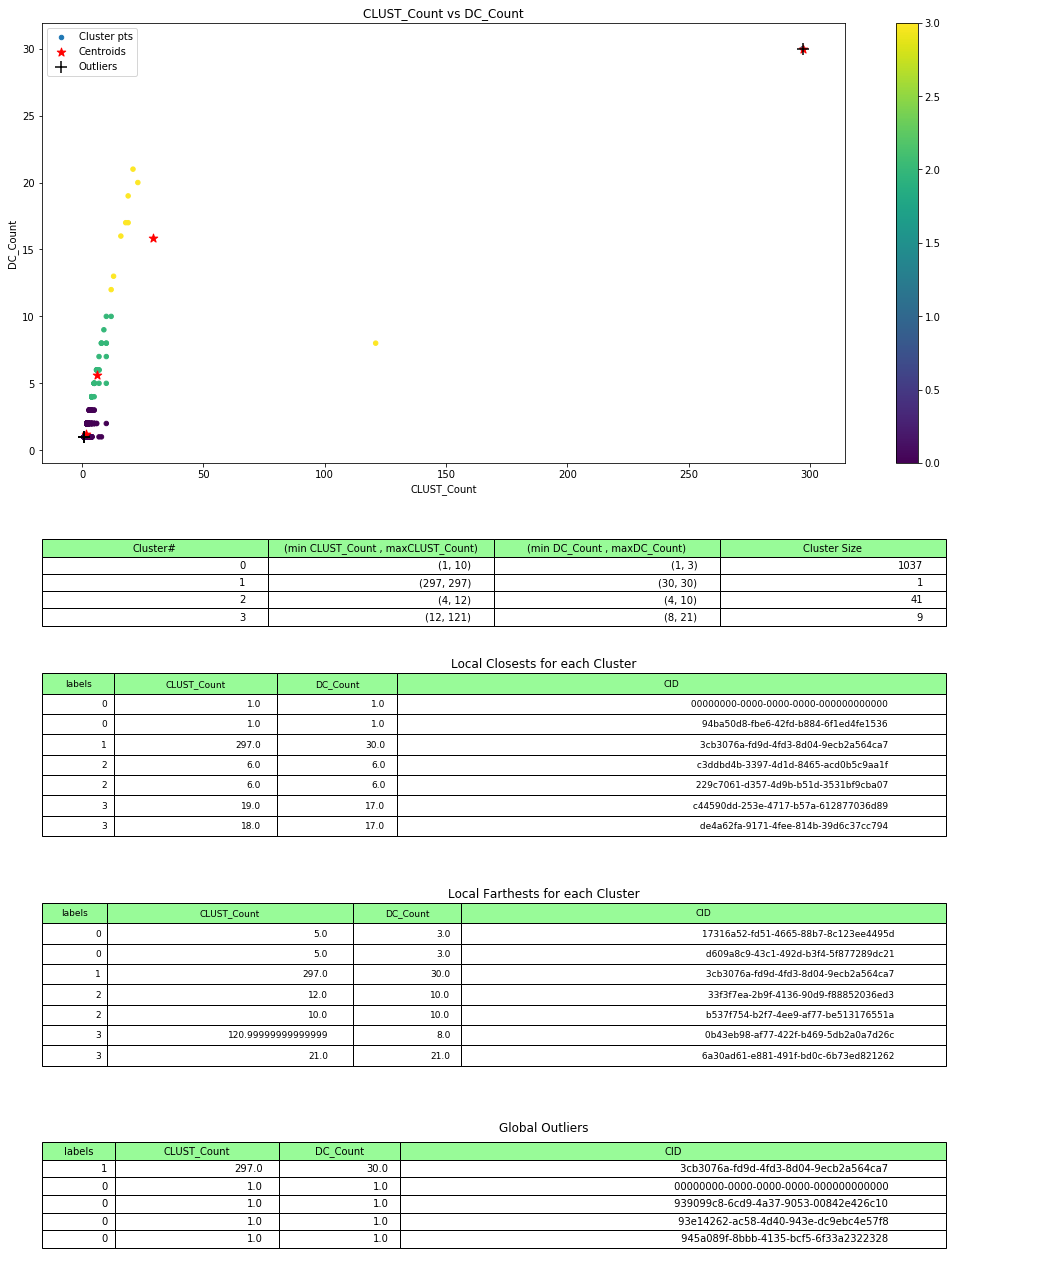

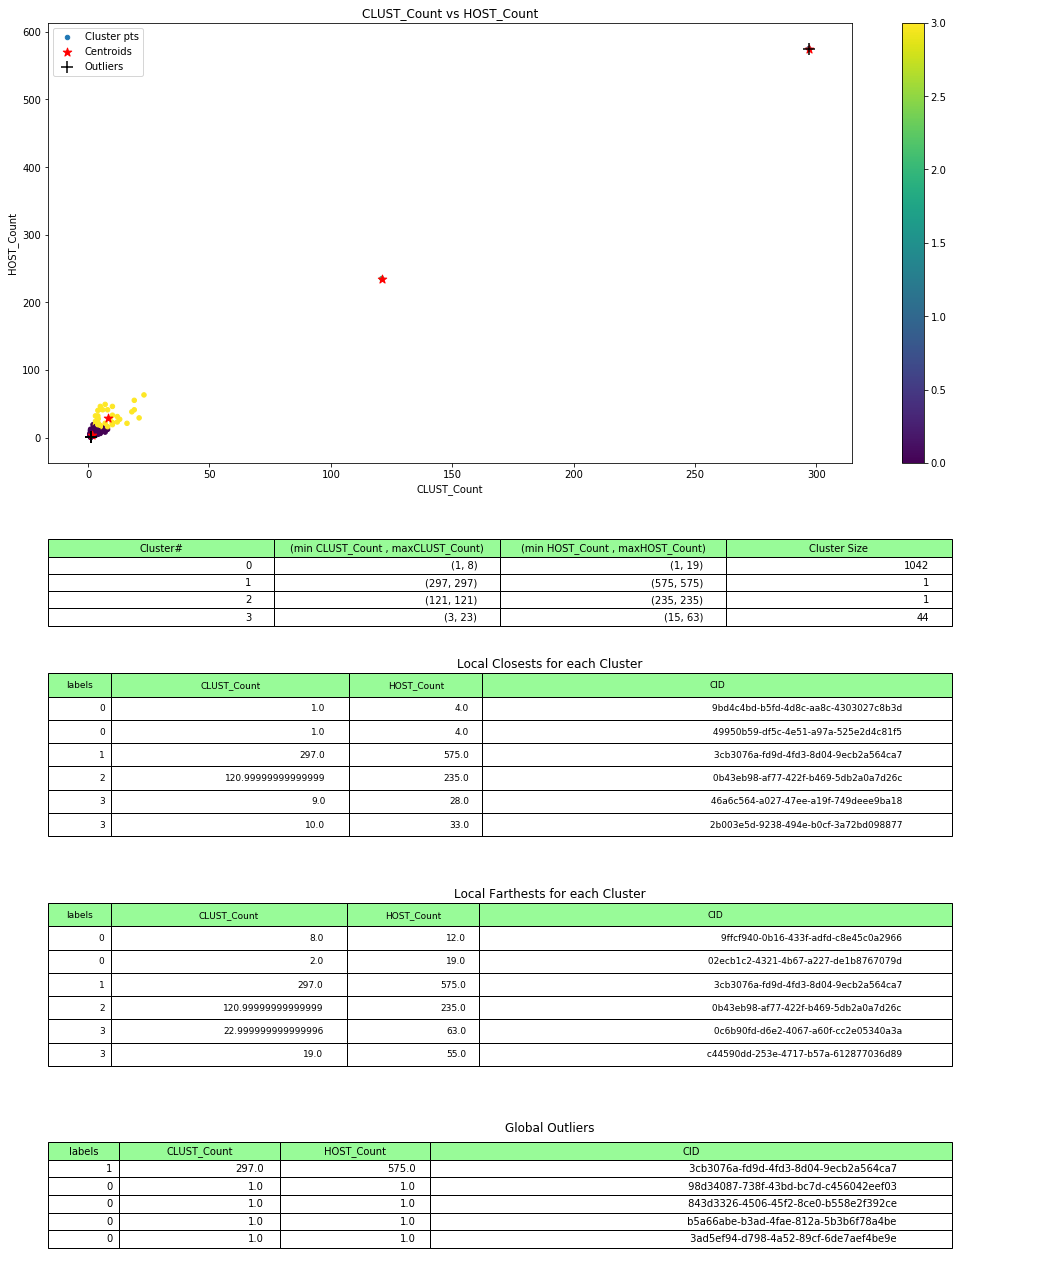

In [13]:
pair_list = [['CLUST_Count', 'DC_Count'], ['CLUST_Count', 'HOST_Count']]
cluster_pair_list(df_customer, pair_list, 2)     

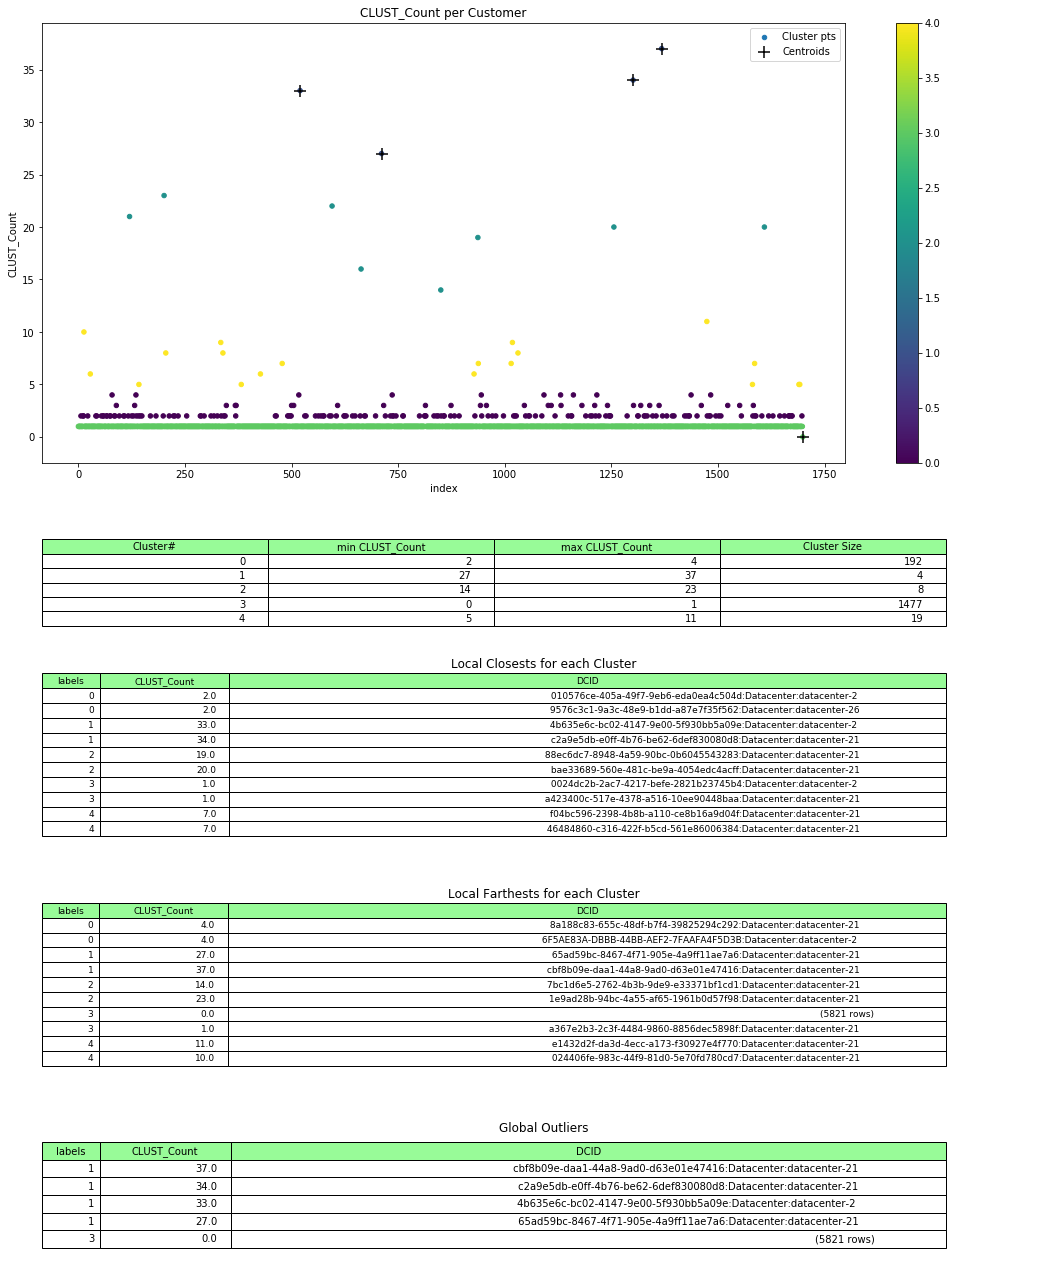

In [14]:
df1 = data[['DCID', 'CLUSTID']]
df1 = df1.groupby(by='DCID', as_index=False).agg({'CLUSTID': pd.Series.nunique})
df1 = df1.rename(columns={'CLUSTID': 'CLUST_Count'})
cluster_pair_list(df1, [['CLUST_Count']], 2)

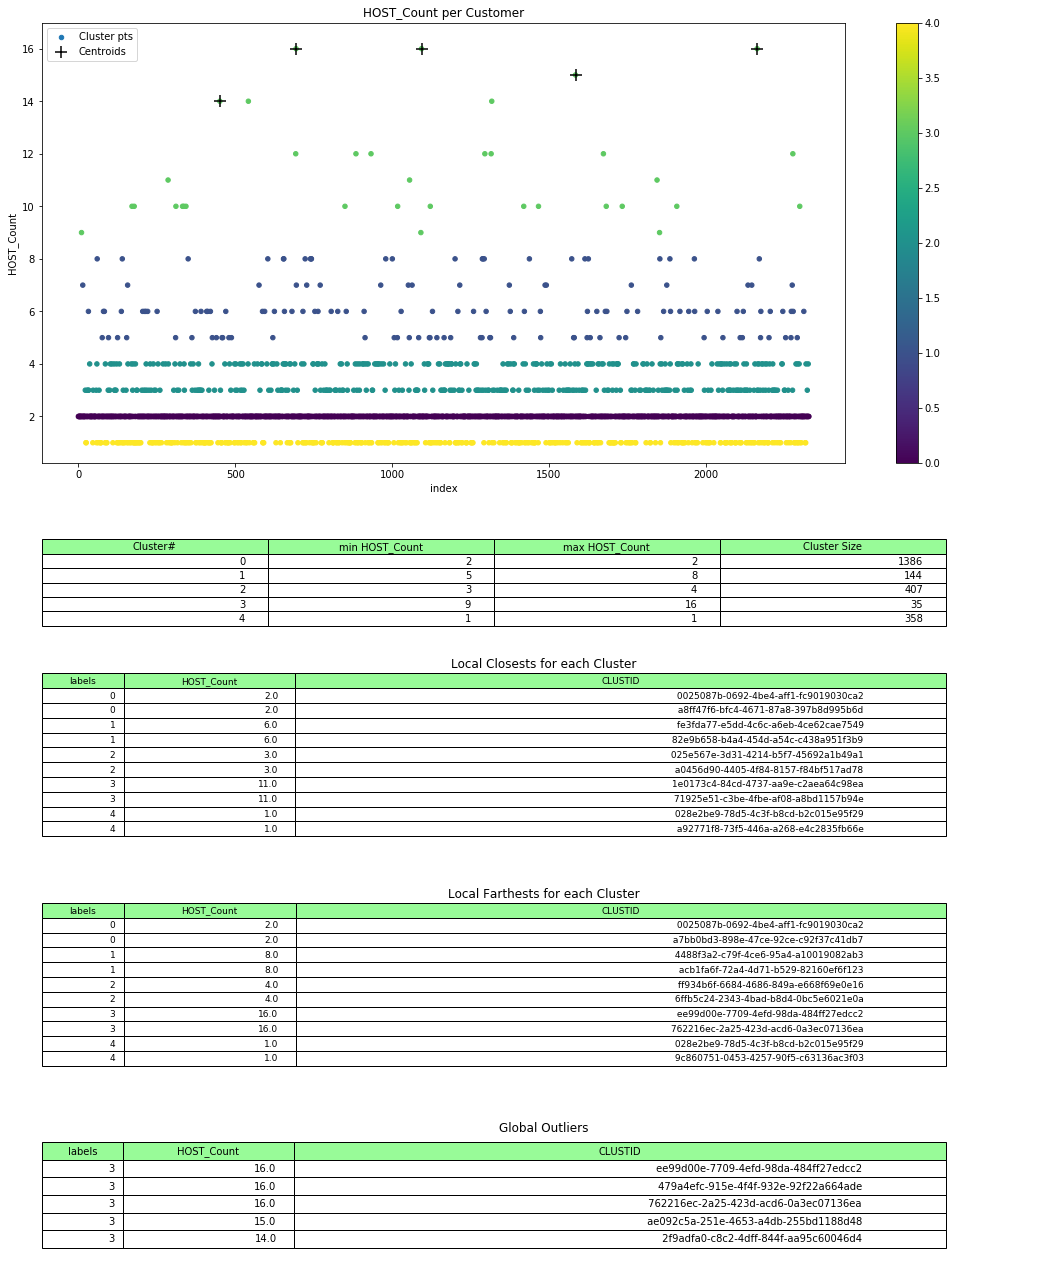

In [15]:
df2 = data[['CLUSTID', 'HOSTID']]
df2 = df2.groupby(by='CLUSTID', as_index=False)['HOSTID'].count()
df2 = df2.rename(columns={'HOSTID': 'HOST_Count'})
cluster_pair_list(df2, [['HOST_Count']], 2)

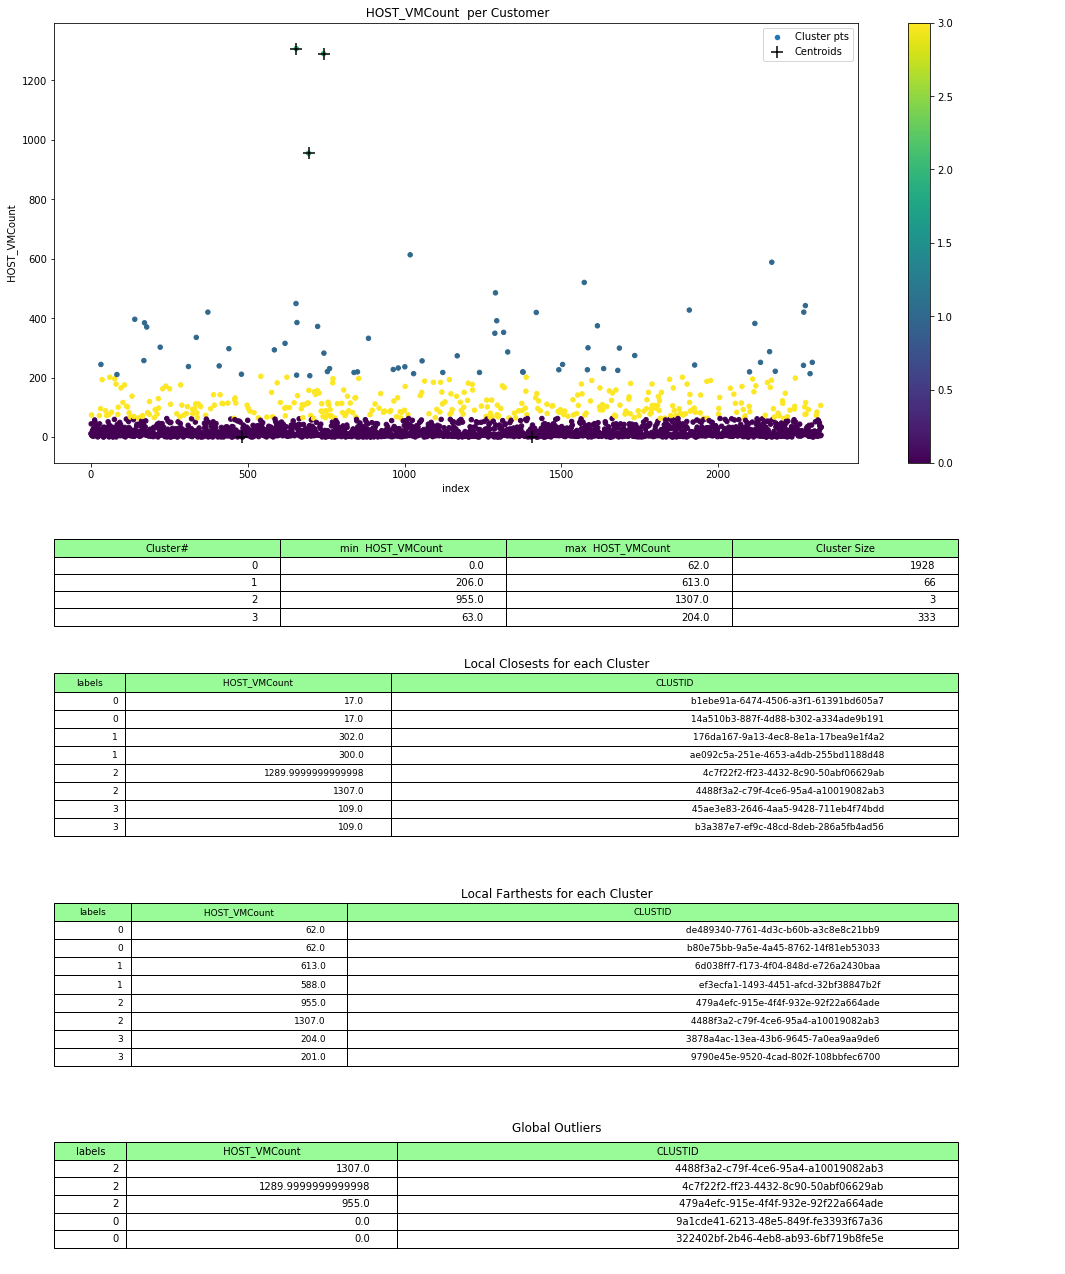

In [16]:
df3 = data[['CLUSTID', ' HOST_VMCount ']]
df3 = df3.groupby(by='CLUSTID', as_index=False)[' HOST_VMCount '].sum()
cluster_pair_list(df3, [[' HOST_VMCount ']], 2)

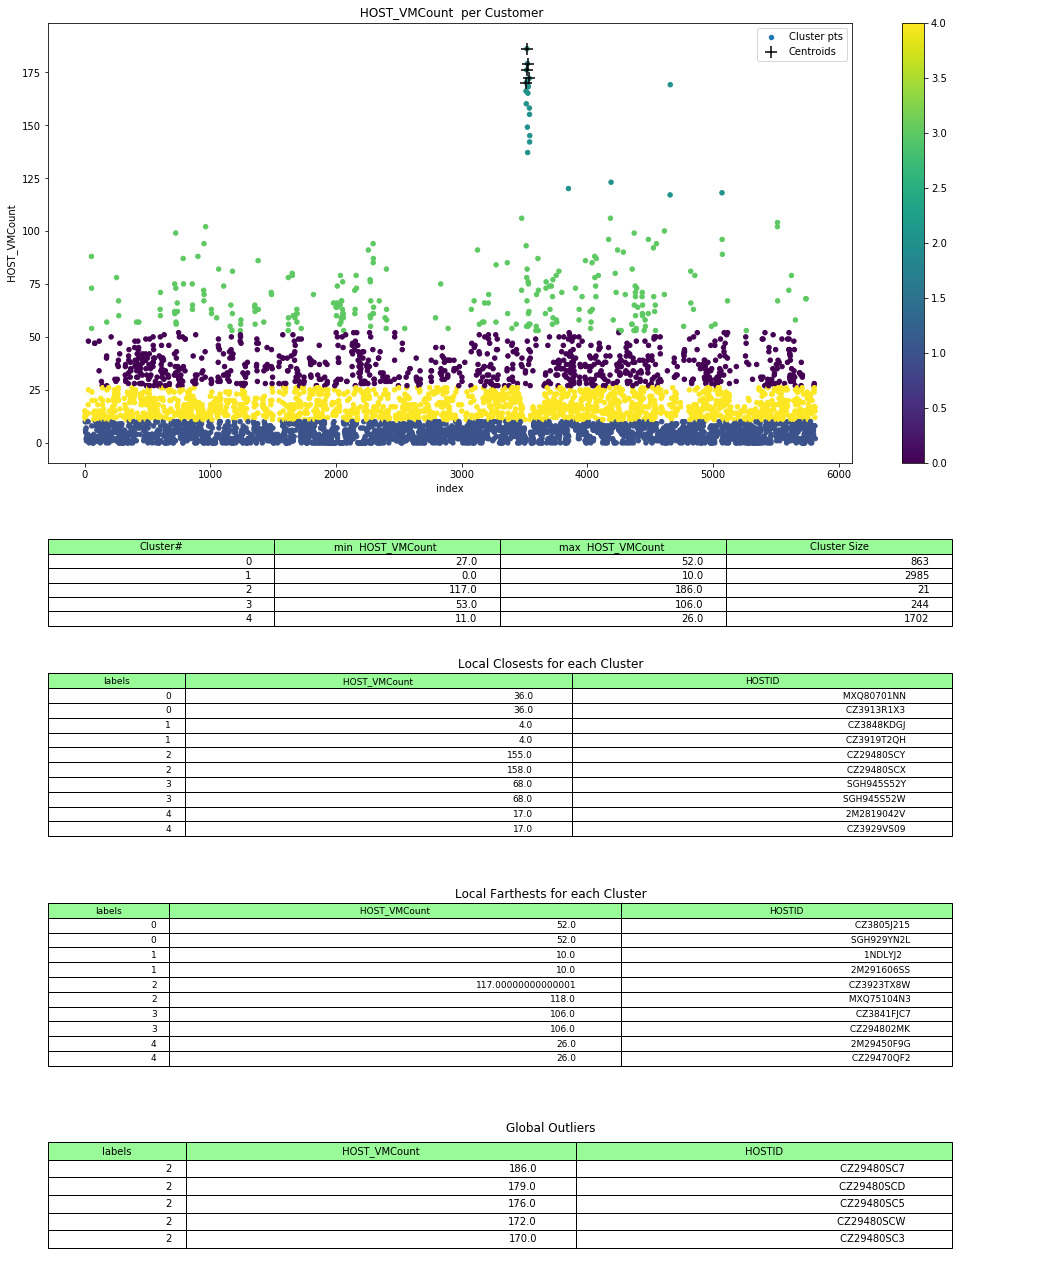

In [17]:
df4 = data[['HOSTID', ' HOST_VMCount ']]
df4 = df4.groupby(by='HOSTID', as_index=False)[' HOST_VMCount '].sum()
cluster_pair_list(df4, [[' HOST_VMCount ']], 2)

In [ ]:
# def k_opt_silhoutee(df):
#     K = range(2,10)
#     score = []
#     for k in K: 
#         kmeans = KMeans(n_clusters=k).fit(df) 
#         kmeans.fit_transform(df)     
#         score.append(silhouette_score(df, kmeans.labels_))
#     max_score = -999
#     ind = 0
#     for i in range(len(score)):
#         if max_score < score[i]:
#             max_score = score[i]
#             ind = i+2
#     return (ind)

In [17]:
# from collections import Counter, defaultdict
# from tabulate import tabulate
# pair = ['DC_Count']
# df = df_customer[pair]
# kmeans = KMeans(n_clusters=4)
# kmeans.fit_transform(df)
# clusters_indices = defaultdict(list)
# for index, c  in enumerate(kmeans.labels_):
#     clusters_indices[c].append(index)
# table_rows = []
# if len(pair) == 2:
#     for i in range (len(clusters_indices)):
#         table_rows.append([i, (df.iloc[min(clusters_indices[i]),0], df.iloc[min(clusters_indices[i]),1]), (df.iloc[max(clusters_indices[i]),0], df.iloc[max(clusters_indices[i]),1])])
#     headers = ['Cluster#', 'min (' + pair[0]+' , '+ pair[1] +')', 'max (' + pair[0]+' , '+ pair[1] +')']
# elif len(pair) == 1:
#     for i in range (len(clusters_indices)):
#         table_rows.append([i, min(df.iloc[clusters_indices[i],0]), max(df.iloc[clusters_indices[i],0])])
#     headers = ['Cluster#', 'min ' + pair[0], 'max ' + pair[0]]
# print(tabulate(table_rows, headers = headers))

In [18]:
# import plotly.graph_objects as go
# fig = go.Figure(data=[go.Table(header=dict(values=headers), cells=dict(values=table_rows))])
# fig.show()